> # AIDA with Transfer Learning

In [6]:
!nvidia-smi

Fri Mar 19 10:02:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   71C    P0    N/A /  N/A |    623MiB /  4040MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports

In [7]:
!pip install gdown

In [8]:
#os.environ['CUDA_VISIBLE_DEVICES']='-1' 

In [9]:
import pandas as pd
import numpy as np
import os
import gdown
import math

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa


#from wcs.google import google_drive_share
import pandas as pd
import urllib.request
from urllib.parse import urlparse

#from google.colab import drive


import warnings
warnings.simplefilter(action='ignore')
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Load Data

In [10]:
BASE_DIR ="./"
#IMAGES_DIR = "/kaggle/input/movie-poster-genre-2021/images/"
IMAGES_DIR = "/kaggle/input/moviepostergenre20212/images/"
IMAGES_DIR = "/kaggle/input/moviepostergenre20212/images/images/"
IMAGES_DIR = "../../../../../rainerenglisch-AIDA_movie_genre_cdn2/images/"

In [11]:
#!ls $IMAGES_DIR

In [12]:
fname = IMAGES_DIR + "8Y0aOxqSetK3hXKPFDTrHwu6dWa.jpg"
print(fname)
print(os.path.exists(fname))
print(os.path.exists("/kaggle/input/moviepostergenre20212/images/images/8Y0aOxqSetK3hXKPFDTrHwu6dWa.jpg"))

../../../../../rainerenglisch-AIDA_movie_genre_cdn2/images/8Y0aOxqSetK3hXKPFDTrHwu6dWa.jpg
True
False


# Preproc

In [13]:
#https://drive.google.com/file/d/1VGMVj1keT6FWxlC0SWr0BHpvYcmaQgrV/view?usp=sharing
url = 'https://drive.google.com/uc?id=1MlXZKtRUP7pOehDR9j5MMvBNXF4UNNUx'
url = 'https://drive.google.com/uc?id=1VGMVj1keT6FWxlC0SWr0BHpvYcmaQgrV'
holdout_fname = "df_holdout.csv"
if not os.path.exists(holdout_fname):
    gdown.download(url, holdout_fname, quiet=False)
    df_holdout = pd.read_csv(holdout_fname,sep=";")
    df_holdout.head()

#Bitte diese 1000 Movie IDs vom Training und vom gesamten Model Engineering ausschließen und 
#nur für die Einträge im Leaderboard verwenden.

In [14]:
def retrieve_filename(url):
    a = urlparse(url)
    picfilename = os.path.basename(a.path)
    return picfilename


In [15]:
parquet_fname = "df.parquet.gzip"
#!rm $parquet_fname

In [16]:
url = 'https://drive.google.com/uc?id=1ynvEZMYRonM2SuJ9mQ4kCkznMW6dsqcA'
gdown.download(url, parquet_fname, quiet=False)
df = pd.read_parquet(parquet_fname)
df['genre_id'] = df['genre_id'].apply(lambda x: list(x))

df.head()

Downloading...
From: https://drive.google.com/uc?id=1ynvEZMYRonM2SuJ9mQ4kCkznMW6dsqcA
To: /home/rainer/dev/AIDA2/movie_genre/github/notebooks/rainer/transfer_learning1/df.parquet.gzip
18.5MB [00:01, 12.1MB/s]


,adult,id,original_title,popularity,video,url,poster_url,genre_id,filename,file_exists,is_holdout
380003,False,537250,¿Por qué ya no me quieres?,1.40,False,https://www.themoviedb.org/movie/537250,https://www.themoviedb.org/t/p/w500//8Y0aOxqSe...,"[80, 18]",8Y0aOxqSetK3hXKPFDTrHwu6dWa.jpg,True,False
380010,False,537266,Success,0.60,False,https://www.themoviedb.org/movie/537266,https://www.themoviedb.org/t/p/w500//tJMm1JJUe...,[18],tJMm1JJUeWOLb4nPDBD6sZvFYU3.jpg,True,False
380017,False,537274,Предел возможного,0.62,False,https://www.themoviedb.org/movie/537274,https://www.themoviedb.org/t/p/w500//h9aXCUZ6g...,[18],h9aXCUZ6gj6V5NFv8a31J1OiDjq.jpg,True,False
380020,False,537277,母親,0.60,False,https://www.themoviedb.org/movie/537277,https://www.themoviedb.org/t/p/w500//3Ogn8SWj2...,[18],3Ogn8SWj29GpGHNSIkMYiKZdeBL.jpg,True,False
380022,False,537281,1+1=3 Ora Tinjon,0.60,False,https://www.themoviedb.org/movie/537281,https://www.themoviedb.org/t/p/w500//47yYJPL2q...,[18],47yYJPL2qU9LNQ2rTMs7p3RtfR7.jpg,True,False


In [17]:
type(df['genre_id'].head().iloc[1])


list

In [18]:
%%time
if not os.path.exists(parquet_fname):
    url = 'https://drive.google.com/uc?id=178mXeXUC1400lj-LrWyhD3yfW5_KsVYw'
    gdown.download(url, parquet_fname, quiet=False)
    df = pd.read_parquet(parquet_fname)
    
    df["filename"] = df.loc[~df["poster_url"].isnull(),"poster_url"].apply(retrieve_filename)
    
    
     # set data path to basename of the file
    #df['data_path'] = df['poster_path'].apply(lambda x: x.split('/')[-1])
       # use only mot null rows
    df = df.dropna()

    # remove rows with empty genre_id list and set correct list type
    df['genre_id'] = df['genre_id'].apply(lambda x: np.nan if len(eval(x)) == 0 else x)
    df = df.dropna()
    df['genre_id'] = df['genre_id'].apply(lambda x: eval(x))
    print(f'len of df: {len(df)}')
    print("Checking existence of images")
    df["file_exists"] = df["filename"].apply(lambda x: os.path.exists(IMAGES_DIR + x))
    print("Flagging hold out images")
    df["is_holdout"] = False
    df.loc[df["id"].isin(df_holdout["id"]),"is_holdout"] = True

    df.to_parquet(parquet_fname,compression='gzip')
else:
    df = pd.read_parquet(parquet_fname)


    

CPU times: user 647 ms, sys: 125 ms, total: 771 ms
Wall time: 524 ms


In [19]:
df.head()

,adult,id,original_title,popularity,video,url,poster_url,genre_id,filename,file_exists,is_holdout
380003,False,537250,¿Por qué ya no me quieres?,1.40,False,https://www.themoviedb.org/movie/537250,https://www.themoviedb.org/t/p/w500//8Y0aOxqSe...,"[80, 18]",8Y0aOxqSetK3hXKPFDTrHwu6dWa.jpg,True,False
380010,False,537266,Success,0.60,False,https://www.themoviedb.org/movie/537266,https://www.themoviedb.org/t/p/w500//tJMm1JJUe...,[18],tJMm1JJUeWOLb4nPDBD6sZvFYU3.jpg,True,False
380017,False,537274,Предел возможного,0.62,False,https://www.themoviedb.org/movie/537274,https://www.themoviedb.org/t/p/w500//h9aXCUZ6g...,[18],h9aXCUZ6gj6V5NFv8a31J1OiDjq.jpg,True,False
380020,False,537277,母親,0.60,False,https://www.themoviedb.org/movie/537277,https://www.themoviedb.org/t/p/w500//3Ogn8SWj2...,[18],3Ogn8SWj29GpGHNSIkMYiKZdeBL.jpg,True,False
380022,False,537281,1+1=3 Ora Tinjon,0.60,False,https://www.themoviedb.org/movie/537281,https://www.themoviedb.org/t/p/w500//47yYJPL2q...,[18],47yYJPL2qU9LNQ2rTMs7p3RtfR7.jpg,True,False


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267974 entries, 380003 to 19999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   adult           267974 non-null  bool   
 1   id              267974 non-null  int64  
 2   original_title  267974 non-null  object 
 3   popularity      267974 non-null  float64
 4   video           267974 non-null  bool   
 5   url             267974 non-null  object 
 6   poster_url      267974 non-null  object 
 7   genre_id        267974 non-null  object 
 8   filename        267974 non-null  object 
 9   file_exists     267974 non-null  bool   
 10  is_holdout      267974 non-null  bool   
dtypes: bool(4), float64(1), int64(1), object(5)
memory usage: 17.4+ MB


In [21]:
df.is_holdout.value_counts()

False    266994
True        980
Name: is_holdout, dtype: int64

In [22]:
df.file_exists.value_counts()
#print(df.shape)

True     267937
False        37
Name: file_exists, dtype: int64

In [23]:
#keep only rows where file exists in data set
df = df.loc[df["file_exists"]]

In [24]:
df.loc[~df.is_holdout].shape

(266957, 11)

In [25]:
df.loc[df.is_holdout].shape

(980, 11)

In [26]:
df.loc[df.is_holdout].head()

,adult,id,original_title,popularity,video,url,poster_url,genre_id,filename,file_exists,is_holdout
6,False,3,Varjoja paratiisissa,7.863,False,https://www.themoviedb.org/movie/3,https://www.themoviedb.org/t/p/w500//nj01hspaw...,"[18, 35]",nj01hspawPof0mJmlgfjuLyJuRN.jpg,True,True
26,False,27,9 Songs,20.807,False,https://www.themoviedb.org/movie/27,https://www.themoviedb.org/t/p/w500//91O7z0vo7...,"[18, 10402, 10749]",91O7z0vo7MiNWd5xD2BoivwbQsb.jpg,True,True
27,False,28,Apocalypse Now,21.502,False,https://www.themoviedb.org/movie/28,https://www.themoviedb.org/t/p/w500//gQB8Y5RCM...,"[18, 10752]",gQB8Y5RCMkv2zwzFHbUJX3kAhvA.jpg,True,True
30,False,32,大砲の街,4.836,False,https://www.themoviedb.org/movie/32,https://www.themoviedb.org/t/p/w500//uqAB40iXw...,"[16, 36]",uqAB40iXwb0yGRHfI9xDqYR2A2p.jpg,True,True
48,False,74,War of the Worlds,22.601,False,https://www.themoviedb.org/movie/74,https://www.themoviedb.org/t/p/w500//6Biy7R9Lf...,"[12, 53, 878]",6Biy7R9LfumYshur3YKhpj56MpB.jpg,True,True


 Create ImageGenerators

In [27]:
df['genre_id'] = df['genre_id'].apply(lambda x: list(x))


In [28]:
%%time
datagen = ImageDataGenerator(rescale=1 / 255.)#, validation_split=0.1)
BATCH_SIZE = 64
train_generator = datagen.flow_from_dataframe(
    dataframe=df.loc[~df.is_holdout],
    directory=IMAGES_DIR,
    x_col="filename",
    y_col="genre_id",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",    
    target_size=(299, 299),
    subset='training',
    validate_filenames=False
)


Found 266957 non-validated image filenames belonging to 19 classes.
CPU times: user 968 ms, sys: 56.4 ms, total: 1.02 s
Wall time: 1.03 s


In [29]:
%%time
#datagen = ImageDataGenerator(rescale=1 / 255.)#, validation_split=0.1)
valid_generator = datagen.flow_from_dataframe(
    dataframe=df.loc[df.is_holdout],
    directory=IMAGES_DIR,
    x_col="filename",
    y_col="genre_id",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=False,
    class_mode="categorical",
    target_size=(299, 299),
    subset='training',
    validate_filenames=False,
)

Found 980 non-validated image filenames belonging to 19 classes.
CPU times: user 18.8 ms, sys: 550 µs, total: 19.4 ms
Wall time: 17.6 ms


%%time
datagen = ImageDataGenerator(rescale=1 / 255., validation_split=0.1)
BATCH_SIZE = 64
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=IMAGES_DIR,
    x_col="filename",
    y_col="genre_id",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",    
    target_size=(299, 299),
    subset='training',
    validate_filenames=True
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=IMAGES_DIR,
    x_col="filename",
    y_col="genre_id",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(299, 299),
    subset='validation',
    validate_filenames=True
)

In [30]:
# show class indicies
print(train_generator.class_indices)
print('length:', len(train_generator.class_indices))


{12: 0, 14: 1, 16: 2, 18: 3, 27: 4, 28: 5, 35: 6, 36: 7, 37: 8, 53: 9, 80: 10, 99: 11, 878: 12, 9648: 13, 10402: 14, 10749: 15, 10751: 16, 10752: 17, 10770: 18}
length: 19


In [31]:
list(train_generator.class_indices.keys())

[12,
 14,
 16,
 18,
 27,
 28,
 35,
 36,
 37,
 53,
 80,
 99,
 878,
 9648,
 10402,
 10749,
 10751,
 10752,
 10770]

In [32]:
#https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras
from sklearn.utils import class_weight
#In order to calculate the class weight do the following

class_weights = class_weight.compute_class_weight('balanced',
                                                  np.array(list(train_generator.class_indices.keys()),dtype="int"), 
                                                  np.array(df.genre_id.explode(),dtype="int"))

class_weights_genre_id = dict(zip(list(train_generator.class_indices), class_weights))
display(class_weights_genre_id)
class_weights = dict(zip(list(range(len(class_weights))), class_weights))
class_weights

{12: 1.8200993419517049,
 14: 2.387359612420172,
 16: 1.2594883623401132,
 18: 0.23874570695921116,
 27: 1.0940343657160017,
 28: 0.9769371436609564,
 35: 0.36242949853758133,
 36: 3.341485051007751,
 37: 5.326442814686991,
 53: 0.99210079907147,
 80: 1.4068035866321043,
 99: 0.46450244906191573,
 878: 2.2659566875344113,
 9648: 2.5898081304223695,
 10402: 1.1858740225125597,
 10749: 0.9049801486307645,
 10751: 1.6559592866217359,
 10752: 4.401455661731941,
 10770: 2.5843721654999188}

{0: 1.8200993419517049,
 1: 2.387359612420172,
 2: 1.2594883623401132,
 3: 0.23874570695921116,
 4: 1.0940343657160017,
 5: 0.9769371436609564,
 6: 0.36242949853758133,
 7: 3.341485051007751,
 8: 5.326442814686991,
 9: 0.99210079907147,
 10: 1.4068035866321043,
 11: 0.46450244906191573,
 12: 2.2659566875344113,
 13: 2.5898081304223695,
 14: 1.1858740225125597,
 15: 0.9049801486307645,
 16: 1.6559592866217359,
 17: 4.401455661731941,
 18: 2.5843721654999188}

In [33]:
map_gender={"28":"Action",
"12":"Adventure",
"16":"Animation",
"35":"Comedy",
"80":"Crime",
"99":"Documentary",
"18":"Drama",
"10751":"Family",
"14":"Fantasy",
"36":	"History",
"27":"Horror",
"10402"	:"Music",
"9648":"Mystery",
"10749":"Romance",
"878"	:"Science Fiction",
"10770":"TV Movie",
"53":"Thriller",
"10752":"War",
"37":"Western"}

series_genre_id_counts = df.genre_id.explode().value_counts()
series_genre_id_counts
df_genre = pd.DataFrame(series_genre_id_counts)
df_genre["id"] = df_genre.index
df_genre.rename(columns={"genre_id" : "count"},inplace=True)
df_genre["name"] = df_genre["id"].apply(lambda x : map_gender[str(x)])
df_genre["weight"] = df_genre["id"].apply(lambda x : class_weights_genre_id[x])
df_genre.sort_values(by="count")

,count,id,name,weight
37,4392,37,Western,5.326443
10752,5315,10752,War,4.401456
36,7001,36,History,3.341485
9648,9033,9648,Mystery,2.589808
10770,9052,10770,TV Movie,2.584372
14,9799,14,Fantasy,2.387360
878,10324,878,Science Fiction,2.265957
12,12853,12,Adventure,1.820099
10751,14127,10751,Family,1.655959
80,16629,80,Crime,1.406804


# Simple Model

In [34]:
#https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.densenet import DenseNet169

from keras.models import Model

def model_create():
    # load model
    #model = VGG16(include_top=False,  input_shape=(299,299, 3))
    model = DenseNet169(include_top=False,  input_shape=(299,299, 3))

    # summarize the model
    #display(model.summary())
    # try global average pooling instead flatten
    
    #x= layers.Flatten()(model.layers[-1].output)
    x=layers.GlobalMaxPool2D()(model.layers[-1].output)
    
    #x= layers.Dense(128, activation='relu')(x)
    x= layers.Dense(1024, activation='relu')(x)
    x= layers.Dense(128, activation='relu')(x)
    
    #x= layers.Dropout(0.5)(x)
    classifications = layers.Dense(len(train_generator.class_indices), activation='sigmoid')(x)
    
    model = Model(inputs=model.inputs, outputs=classifications)

    return model



Finally, we implemented a standard DenseNet-169 architecture with similar modifications. The final
fully-connected layer of 1000 units was once again replaced by 3 sequential fully-connected layers of
3
1024, 128, and 7 units with ReLU, ReLU, and sigmoid activations respectively. The entire model
consists of 14,479,943 parameters, out of which, 14,321,543 were trainable.

In [35]:
fname_model = BASE_DIR + "DenseNet169_1"

import os.path

fname_model = BASE_DIR + "DenseNet169_1"

if  os.path.exists(fname_model) :
    print("Load model")
    model = keras.models.load_model(fname_model, custom_objects={'_tf_keras_metric':f1_micro})


In [36]:
!mkdir model_checkpoints

mkdir: das Verzeichnis »model_checkpoints“ kann nicht angelegt werden: Die Datei existiert bereits


In [37]:
print("create model")
model = model_create()
print("compile model")

create model
compile model


In [38]:
checkpoint_path =  "model_checkpoints/saved-model-06-0.46.hdf5"
model.load_weights(checkpoint_path)

In [39]:
 # mark loaded layers as not trainable
    # except last layer

leng = len(model.layers)
print(leng)
for i,layer in enumerate(model.layers):
    if leng-i == 5:
      print("stopping at",i)
      break
    layer.trainable = False

599
stopping at 594


In [53]:
from keras import metrics
threshold = 0.35
f1_micro = tfa.metrics.F1Score(num_classes=19, average='micro', name='f1_micro',threshold=threshold), 
f1_macro = tfa.metrics.F1Score(num_classes=19, average='macro', name='f1_macro',threshold=threshold)
f1_weighted = tfa.metrics.F1Score(num_classes=19,  average='weighted', name='f1_score_weighted',threshold=threshold)


In [96]:


#https://neptune.ai/blog/keras-metrics
# detect and init the TPU
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
#with tpu_strategy.scope():

model.compile(optimizer='adam', loss="binary_crossentropy", 
          metrics=["categorical_accuracy",
                   tf.keras.metrics.AUC(multi_label = True),#,label_weights=class_weights),
                    f1_micro,
                    f1_macro,
                    f1_weighted,
                  ])
print("create callbacks")
from keras.callbacks import ModelCheckpoint

filepath = "model_checkpoints/saved-model-{epoch:02d}-{val_f1_score_weighted:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_f1_score_weighted', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]



create callbacks


In [106]:
print("model fit")
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=1,# 5,
    # reduce steps per epochs for faster epochs
    #steps_per_epoch = math.ceil(266957 / BATCH_SIZE /8),
    #class_weight = class_weights,
    callbacks=callbacks_list,
    #use_multiprocessing=True
)

model fit
4172/4172 [==============================] - 3529s 846ms/step - loss: 0.2106 - categorical_accuracy: 0.4605 - auc_1: 0.7965 - f1_micro: 0.4713 - f1_macro: 0.3092 - f1_score_weighted: 0.4270 - val_loss: 0.2866 - val_categorical_accuracy: 0.4071 - val_auc_1: 0.7952 - val_f1_micro: 0.4695 - val_f1_macro: 0.3100 - val_f1_score_weighted: 0.4202

Epoch 00001: val_f1_score_weighted did not improve from 0.45863


In [107]:
!mkdir final_model
!mkdir final_model_weights

mkdir: das Verzeichnis »final_model“ kann nicht angelegt werden: Die Datei existiert bereits
mkdir: das Verzeichnis »final_model_weights“ kann nicht angelegt werden: Die Datei existiert bereits


In [108]:
print("Saving final model")

model.save("final_model/" + fname_model)
print("Saving final model weights")

model.save_weights("final_model_weights/" + fname_model + ".ckpt")
#load_status = sequential_model.load_weights("ckpt")

Saving final model
INFO:tensorflow:Assets written to: final_model/./DenseNet169_1/assets
Saving final model weights


In [154]:
y_pred = model.predict(valid_generator)

In [155]:
y_pred.shape

(980, 19)

In [158]:
y_true = [ [1 if i in e else 0 for i in range(19)] for e in valid_generator.labels]
y_true = np.array(y_true)

In [163]:
from sklearn.metrics import f1_score

ths = np.linspace(0.1, 0.5, 10)

pd.DataFrame({
    'threshold': ths, 
    'f1-micro': [f1_score(y_true, (y_pred > th)*1., average="micro") for th in ths],
    'f1-weighted': [f1_score(y_true, (y_pred > th)*1., average="weighted") for th in ths],
    'class' : "all"
    }
)

,threshold,f1-micro,f1-weighted,class
0,0.100000,0.467956,0.475777,all
1,0.144444,0.503044,0.489854,all
2,0.188889,0.517184,0.488811,all
3,0.233333,0.520643,0.483615,all
4,0.277778,0.511047,0.466600,all
5,0.322222,0.494681,0.443013,all
6,0.366667,0.481085,0.427526,all
7,0.411111,0.450195,0.395599,all
8,0.455556,0.404662,0.355617,all
9,0.500000,0.363463,0.317105,all


In [181]:
from sklearn.metrics import f1_score

ths = np.linspace(0.1, 0.5, 9)

df_ths = pd.DataFrame({'threshold' : ths}
)

for cl in range(19):
    col = pd.DataFrame({f'f1-class_{cl}': [f1_score(y_true[:,cl], (y_pred[:,cl] > th)*1.) for th in ths]          
                       })
    df_ths=pd.concat([df_ths,col],axis="columns")

df_ths.style.highlight_max(color = 'lightgreen', axis = 0)
df_ths

,threshold,f1-class_0,f1-class_1,f1-class_2,f1-class_3,f1-class_4,f1-class_5,f1-class_6,f1-class_7,f1-class_8,f1-class_9,f1-class_10,f1-class_11,f1-class_12,f1-class_13,f1-class_14,f1-class_15,f1-class_16,f1-class_17,f1-class_18
0,0.10,0.406877,0.352381,0.580311,0.627393,0.482143,0.456395,0.630189,0.121212,0.400000,0.511696,0.318725,0.181250,0.421053,0.190476,0.168675,0.430177,0.448179,0.303797,0.081081
1,0.15,0.359375,0.362416,0.650307,0.634294,0.527132,0.487633,0.678840,0.036364,0.400000,0.537906,0.329545,0.233333,0.422535,0.054054,0.161616,0.422175,0.538182,0.285714,0.112676
2,0.20,0.317949,0.260870,0.662252,0.649206,0.529148,0.495902,0.694935,0.000000,0.363636,0.502128,0.335766,0.282486,0.422222,0.000000,0.136986,0.435028,0.578723,0.313725,0.156863
3,0.25,0.231707,0.202020,0.661972,0.663851,0.463054,0.508314,0.706179,0.000000,0.380952,0.459658,0.346667,0.302158,0.346154,0.000000,0.147059,0.388158,0.606635,0.260870,0.200000
4,0.30,0.225166,0.152174,0.671642,0.675651,0.417582,0.502762,0.700549,0.000000,0.400000,0.425068,0.297436,0.317757,0.321678,0.000000,0.098361,0.332046,0.571429,0.100000,0.242424
5,0.35,0.142857,0.046512,0.666667,0.681382,0.400000,0.510769,0.672646,0.000000,0.400000,0.409496,0.200000,0.333333,0.287879,0.000000,0.101695,0.294372,0.563218,0.054054,0.206897
6,0.40,0.122137,0.023529,0.689076,0.660317,0.387500,0.478689,0.662441,0.000000,0.333333,0.343234,0.133333,0.268657,0.274809,0.000000,0.071429,0.214634,0.545455,0.000000,0.230769
7,0.45,0.109375,0.023529,0.689076,0.611046,0.337838,0.427046,0.602041,0.000000,0.352941,0.249084,0.083916,0.275862,0.198347,0.000000,0.072727,0.149733,0.520000,0.000000,0.160000
8,0.50,0.065041,0.023529,0.695652,0.575916,0.300000,0.393822,0.555354,0.000000,0.250000,0.158103,0.057971,0.250000,0.121739,0.000000,0.074074,0.069364,0.468085,0.000000,0.173913


In [196]:
argmax_index=df_ths.iloc[:,1:].idxmax(axis=0)
class_thresholds = df_ths.threshold[argmax_index].values
class_thresholds

array([0.1 , 0.15, 0.5 , 0.35, 0.2 , 0.35, 0.25, 0.1 , 0.15, 0.15, 0.25,
       0.35, 0.15, 0.1 , 0.1 , 0.2 , 0.25, 0.2 , 0.3 ])

In [199]:
f1_score(y_true, (y_pred > class_thresholds)*1., average="micro")

0.5289968652037618

In [200]:
f1_score(y_true, (y_pred > class_thresholds)*1., average="weighted")

0.5228241429297649

In [94]:
y_true = np.array(y_true)

In [100]:
y_true[:,3].shape

(980,)

In [99]:
y_pred[:,3].shape

(980,)

In [121]:
#df_genre.sort_values(by="count",ascending=False)[:7]

,count,id,name,weight
18,97986,18,Drama,0.238746
35,64547,35,Comedy,0.362429
99,50363,99,Documentary,0.464502
10749,25850,10749,Romance,0.904980
28,23946,28,Action,0.976937
53,23580,53,Thriller,0.992101
27,21383,27,Horror,1.094034


In [145]:
#valid_generator.class_indices.keys()

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

In [149]:
top_n_genre_ids = df_genre.sort_values(by="count",ascending=False)[:7]
display(top_n_genre_ids)
top_n_genre_col_pos = {i:map_gender[str(e)] for i,e in enumerate(list(valid_generator.class_indices.keys())) if e in top_n_genre_ids.values}
display(top_n_genre_col_pos)
#mask_top_n_genre_ids = [(e in top_n_genre_ids.values) for e in list(valid_generator.class_indices.keys())]
#mask_top_n_genre_ids

,count,id,name,weight
18,97986,18,Drama,0.238746
35,64547,35,Comedy,0.362429
99,50363,99,Documentary,0.464502
10749,25850,10749,Romance,0.904980
28,23946,28,Action,0.976937
53,23580,53,Thriller,0.992101
27,21383,27,Horror,1.094034


{3: 'Drama',
 4: 'Horror',
 5: 'Action',
 6: 'Comedy',
 9: 'Thriller',
 11: 'Documentary',
 15: 'Romance'}

In [109]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
from sklearn.metrics import roc_curve, auc
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=19
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], 
                                  y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

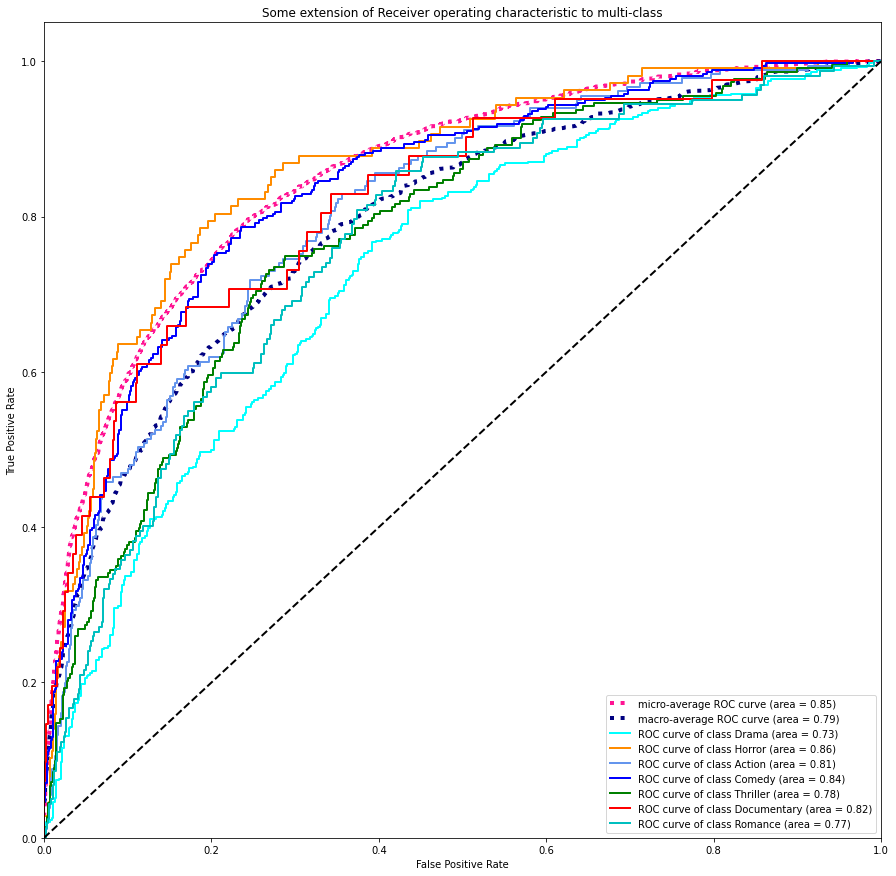

In [152]:
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,15))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'b', 'g', 'r', 'c', 'm', 'y', 'k'])

for i, color in zip(top_n_genre_col_pos.keys(), colors):#zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             #''.format(map_gender[str(i)], roc_auc[i]))
             ''.format(top_n_genre_col_pos[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [124]:
# f1 

,count,id,name,weight
18,97986,18,Drama,0.238746
35,64547,35,Comedy,0.362429
99,50363,99,Documentary,0.464502
10749,25850,10749,Romance,0.904980
28,23946,28,Action,0.976937
53,23580,53,Thriller,0.992101
27,21383,27,Horror,1.094034


[False,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False]